### Load libraries

In [1]:
from DB_and_Azure import sql_db_functions as SQLf

In [2]:
#import streamlit as st
import pandas as pd

In [3]:
from Features import world_constructions as WCf

c:\Users\juand\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
import base64
from io import BytesIO
from PIL import Image


def base64_to_image(base64_string):
    # Remove the data URI prefix if present
    if "data:image" in base64_string:
        base64_string = base64_string.split(",")[1]
    # Decode the Base64 string into bytes
    image_bytes = base64.b64decode(base64_string)
    return image_bytes

def create_image_from_bytes(image_bytes):
    # Create a BytesIO object to handle the image data
    image_stream = BytesIO(image_bytes)

    # Open the image using Pillow (PIL)
    image = Image.open(image_stream)
    return image

def resize_image(image, new_width):
    # Open the image

    # Calculate the new height while maintaining the aspect ratio
    original_width, original_height = image.size
    aspect_ratio = original_height / original_width
    new_height = int(new_width * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    return resized_image

### Loading Postgress

In [5]:
df_retail = WCf.world_construction.init_retail_gallery()
df_retail.head()

,id,prod_id,Detail,Summary,Brand,Price,base64
0,114,114,Type: Top - Shirt / Fit: Loose / Sleeve sty...,"This top is a fluid, long shirt made from a li...",Mango,39.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,145,145,Type: Top - Shirt / Fit: Regular fit / ...,The top showcased in the images is a straight-...,Mango,29.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
2,36,35,Type: Top - Shirt / Fit: Regular fit / ...,The images showcase a versatile top that is a ...,HM,49.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
3,91,89,Type: Top - Shirt / Fit: Regular fit / ...,"The top showcased in the images is a stylish, ...",Mango,39.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
4,39,38,"Type: Top, Shirt / Fit: Regular fit / Sleev...",The top showcased in the images is a classic w...,HM,9.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


In [6]:
df = WCf.world_construction.init_luxury_gallery()
df.head(2)

,id,prod_id,Detail,Summary,Brand,Price,base64
0,2,2,Type: Shirt / Fit: Regular fit / Sleeve...,The shirt depicted in the images is a Gucci Ox...,Gucci,650.0,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,4,4,Type: Shirt / Fit: Regular fit / Sleeve...,The showcased shirt is a luxurious Gucci creat...,Gucci,1300.0,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


In [7]:
i = 1
description = df.iloc[i].Summary
row = df.iloc[i]
detail = df.iloc[i].Detail

df.iloc[i]

id                                                         4
prod_id                                                    4
Detail      Type: Shirt   /  Fit: Regular fit   /  Sleeve...
Summary    The showcased shirt is a luxurious Gucci creat...
Brand                                                  Gucci
Price                                                 1300.0
base64     [data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA...
Name: 1, dtype: object

In [8]:
row['base64'][-len(row['base64'])+1]

'data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAPUA9QDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2eiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKK

In [9]:
description

"The showcased shirt is a luxurious Gucci creation, exuding an elegant and summery vibe inspired by beach clubs. This top features a relaxed fit with long sleeves and buttoned cuffs, ideal for a comfortable yet stylish look. The neckline is a classic button-up style with a pointed collar, adding a touch of formality. Crafted from high-quality silk, the shirt is lightweight and breathable, perfect for warm-weather wear. The primary colors are a soft pastel pink and white, creating a delicate and sophisticated palette. The shirt's texture is smooth and silky, enhancing its fluidity and drape. It is adorned with distinctive horsebit and stripe patterns – the horsebit motif is a nod to Gucci's equestrian heritage, placed strategically across the shirt to create a cohesive design. The stripes run vertically, elongating the figure and adding a structured element to the fluid fabric. There are no pockets, maintaining a sleek and uninterrupted silhouette. This shirt is suitable for semi-formal

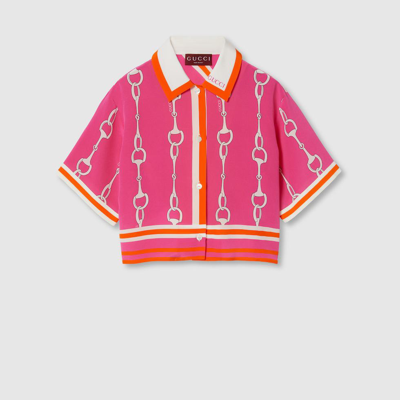

In [10]:
resize_image(
    create_image_from_bytes(image_bytes=base64_to_image( row['base64'][1]   )),
    400)

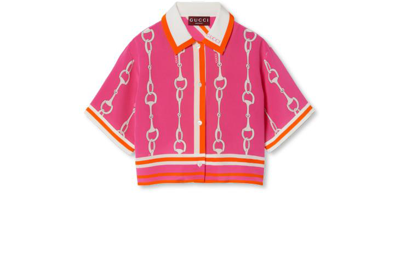

In [11]:
resize_image(
    create_image_from_bytes(image_bytes=base64_to_image( row['base64'][0]   )),
    400)

### Loading Chroma

In [12]:
vectorestore = WCf.world_construction.init_chroma_db()

c:\Users\juand\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


In [13]:
query = "Summer"
docs = vectorestore.similarity_search_with_relevance_scores(query,filter= {'Type':'Retail'},k=10)

In [14]:
# Import the necessary libraries
from sentence_transformers import CrossEncoder
import numpy as np

In [15]:
# Initialize the Cross Encoder model
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)

# Extract the documents and their corresponding metadata from the search results
documents = [doc[0].page_content for doc in docs]

c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [16]:
# Rerank the documents using the Cross Encoder model
scores = model.predict([(query, doc) for doc in documents])

# Get the indices of the top-scoring documents
top_indices = np.argsort(scores, axis=0)[::-1].flatten()

# Rerank the original documents based on the scores
reranked_docs = [docs[i] for i in top_indices]


In [17]:
reranked_docs

[(Document(page_content='spring and summer. The shirt comes in a neutral beige color, which is versatile and can be easily paired with various outfits. The fabric has a smooth texture with a slight sheen, suggesting a soft and comfortable feel against the skin. It has no transparency issues, ensuring modesty and coverage. There are no visible pockets, embellishments, or patterns, giving it a clean and minimalist', metadata={'Type': 'Retail', 'doc_id': '58'}),
  0.09612509315634032),
 (Document(page_content='spring and summer. The material appears to be a blend, possibly cotton or a cotton mix, offering a smooth texture with no transparency. The shirt is predominantly white, which is complemented by a subtle checkered pattern in light blue, adding a soft contrast and visual interest. The pattern is evenly distributed across the entire fabric. The shirt’s length is standard, falling just below the', metadata={'Type': 'Retail', 'doc_id': '56'}),
  0.14986063913378977),
 (Document(page_con

### Similarity search 

In [ ]:
import os
import numpy as np

In [ ]:
from DB_and_Azure import apikey
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

In [ ]:
def description_to_concepts(description):

    os.environ['OPENAI_API_KEY'] = apikey.apikey

    # LLM
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)

    # Prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a fashion specialist."),
            ("user", 
                "Hi, im looking forward doing a similarity search in my vector database. I need your help transforming DESCRIPTION into 10 short concepts that summarize the DESCRIPTION. "
                "Answer the concept split by comma in a text format.  "
                "DONT USE BRAND NAMES. "
                " " 
                "DESCRIPTION: {description}")
        ]
    )

    chain = prompt | model

    response = chain.invoke({"description":description})

    return response.content.split(',')


In [ ]:
def recommendation_reranking(docs):

    # Initialize the Cross Encoder model
    model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)

    # Extract the documents and their corresponding metadata from the search results
    documents = [doc[0].page_content for doc in docs]

    # Rerank the documents using the Cross Encoder model
    scores = model.predict([(query, doc) for doc in documents])

    # Get the indices of the top-scoring documents
    top_indices = np.argsort(scores, axis=0)[::-1].flatten()

    # Rerank the original documents based on the scores
    reranked_docs = [docs[i] for i in top_indices]

    return reranked_docs



In [ ]:
def find_similar_items_with_concepts(concepts):

    final_df = pd.DataFrame()

    i = 0
    for content in concepts:

        trim_content = content.lstrip()

        found_items = vectorestore.similarity_search_with_score(trim_content,filter= {'Type':'Retail'},k=15)

        found_items = recommendation_reranking(found_items)
        

        data = []
        for item in found_items:
            doc_id = item[0].metadata['doc_id']
            page_content = item[0].page_content
            int_value = item[1]
            data.append([trim_content,doc_id, page_content, int_value])
        
        cols = ['trim_content','doc_id', 'page_content', 'int_value']

        if i == 0: final_df = pd.DataFrame(data, columns=cols)
        if i>0: 
            final_df = pd.concat([final_df,pd.DataFrame(data, columns=cols)], ignore_index=True) 
            
        i= i+1
    
    final_df.doc_id = final_df.doc_id.astype(int)
    
    return final_df

In [ ]:
def similarity_search(description):


    concepts = description_to_concepts(description)

    final_df = find_similar_items_with_concepts(concepts=concepts)

    ranked_df = final_df.groupby('doc_id').agg(
        count = pd.NamedAgg(column='int_value',aggfunc='count'),
        mean = pd.NamedAgg(column='int_value',aggfunc='mean'),
        score = pd.NamedAgg(column='int_value',aggfunc=lambda x: sum(10-x))
    ).reset_index()

    #ranked_df['mean'] = -ranked_df['mean']

    ranked_df = ranked_df.sort_values(['count','score'],ascending=False).head(6)
    
    ranked_df.reset_index(drop=True,inplace=True)
    #final_df = final_df.merge(ranked_df, on='doc_id',how='inner')[['trim_content','doc_id','page_content']]

    return ranked_df

    

In [ ]:
simiarity_recomentation_df = similarity_search(description = description)

In [ ]:
simiarity_recomentation_df.head(6)

In [ ]:
i = 2
recommended_item = df_retail[ df_retail.prod_id == simiarity_recomentation_df.iloc[i].doc_id ]

In [ ]:
recommended_item

In [ ]:
i = recommended_item.index
i = i[0]

In [ ]:
resize_image(
    create_image_from_bytes(image_bytes=base64_to_image( recommended_item['base64'][i][0]   )),
    400)

In [ ]:
resize_image(
    create_image_from_bytes(image_bytes=base64_to_image( recommended_item['base64'][i][1]   )),
    400)

### Testing feature 1 from scratch

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain

In [ ]:
from Features import search_from_luxury_brands as Sf

In [ ]:
piece_1 = df_retail[ df_retail.prod_id == simiarity_recomentation_df.iloc[0].doc_id ]
piece_2 = df_retail[ df_retail.prod_id == simiarity_recomentation_df.iloc[1].doc_id ]
piece_3 = df_retail[ df_retail.prod_id == simiarity_recomentation_df.iloc[2].doc_id ]
piece_4 = df_retail[ df_retail.prod_id == simiarity_recomentation_df.iloc[3].doc_id ]
piece_5 = df_retail[ df_retail.prod_id == simiarity_recomentation_df.iloc[4].doc_id ]

In [ ]:
system_prompt = ( f"""
            
            You are an enginee that suggest similar style clothing based on descriptions. 
            Use the following retrieved context and the description of the clothing I have to generate the answer.
            
            \n\n
            Context: 
            Piece_1: {piece_1}
            Piece_2: {piece_2}
            Piece_3: {piece_3}
            Piece_4: {piece_4}
            Piece_5: {piece_5}
                         
            ANSWER ONLY THE FOLLOWING FORM describing how the 5 pieces of clothing are similar to the one i have:
            *Piece_1: Concise Explanation
            *Piece_2: Concise Explanation
            *Piece_3: Concise Explanation
            *Piece_4: Concise Explanation
            *Piece_5: Concise Explanation
            """                         
        )

In [ ]:
prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "{input}"),
            ]
        )

In [ ]:
os.environ['OPENAI_API_KEY'] = apikey.apikey

turbo_llm = ChatOpenAI(
    temperature=0.5,
    model_name='gpt-4o-mini'
)

In [ ]:
chain = prompt | turbo_llm

In [ ]:
response = chain.invoke({"input":description})

In [ ]:
response

In [ ]:
r1 = response.content.replace('\n\n','').split('*')[1:]
r1

In [ ]:
df_r1 = pd.DataFrame(r1,columns=['explanation'])
df_r1.explanation = df_r1.explanation.apply(lambda x: x.replace('Piece_','').replace('1:','').replace('2:','').replace('3:','').replace('4:','').replace('5:',''))

In [ ]:
df_r1

In [ ]:
df_retail[['prod_id','Brand','Price','base64']]

In [ ]:
simiarity_recomentation_df = simiarity_recomentation_df.iloc[0:len(df_r1)].join(df_r1).rename(columns={'doc_id':'prod_id'})

In [ ]:
simiarity_recomentation_df = simiarity_recomentation_df[['prod_id','explanation']].merge(df_retail[['prod_id','Brand','Price','base64']], how= 'inner',on='prod_id')

In [ ]:
simiarity_recomentation_df

### Feature 1: Find similar pieces from luxury brands in retail brands 

In [18]:
from Features import search_from_luxury_brands as Sf

In [19]:
model_crossencoder = WCf.world_construction.init_model_crossencoder()

In [20]:
description

"The showcased shirt is a luxurious Gucci creation, exuding an elegant and summery vibe inspired by beach clubs. This top features a relaxed fit with long sleeves and buttoned cuffs, ideal for a comfortable yet stylish look. The neckline is a classic button-up style with a pointed collar, adding a touch of formality. Crafted from high-quality silk, the shirt is lightweight and breathable, perfect for warm-weather wear. The primary colors are a soft pastel pink and white, creating a delicate and sophisticated palette. The shirt's texture is smooth and silky, enhancing its fluidity and drape. It is adorned with distinctive horsebit and stripe patterns – the horsebit motif is a nod to Gucci's equestrian heritage, placed strategically across the shirt to create a cohesive design. The stripes run vertically, elongating the figure and adding a structured element to the fluid fabric. There are no pockets, maintaining a sleek and uninterrupted silhouette. This shirt is suitable for semi-formal

In [21]:
entity = Sf.seacrh_from_luxury_brands(description=description, vectorstore=vectorestore)

In [22]:
answer = entity.search_similarity_from_description(df_retail=df_retail,model_crossencoder=model_crossencoder)

In [23]:
answer

,prod_id,explanation,Brand,Price,base64
0,113,This loose-fit shirt features a fluid design ...,Mango,29.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,132,This satin-finish top offers a regular fit an...,Mango,39.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
2,120,"With a regular fit and fluid fabric, this shi...",Mango,39.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
3,136,This straight-fit shirt combines a regular fi...,Mango,39.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
4,154,This loose-fit top showcases a fluid fabric s...,Mango,29.99,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


### Organize in daframe for display

## Feature 2: Find pieces from user prompt description ( Text prompt to suggestions)

### Feature 3: Find pieces similar to user provided piece ( Image to suggestions)